# Marginalized Graph Kernel (MGK) Architecture

In [1]:
# How to define the architecture of MGK is still an open question.
# In mgktools package, the architecture of MGK is defined in a json file.
# In default, mgktools provides 8 sets of choices. 
# For details, please refer to:
# Xiang Y, Tang Y H, Liu H, et al. JPCA, 2021, 125(20): 4488-4497.
# Xiang Y, Tang Y H, Lin G, et al. JCIM, 2021, 61(11): 5414-5424.
from mgktools.hyperparameters import product, product_norm, product_msnorm, product_pnorm
from mgktools.hyperparameters import additive, additive_norm, additive_msnorm, additive_pnorm
import json
# product_msnorm means combining different features through product, and using molecular-sized normalization.
# This is used in the JPCA paper.
json.load(open(product_msnorm))

{'Normalization': [10000, [1000, 30000]],
 'a_type': ['Tensorproduct', 'fixed'],
 'atom_AtomicNumber': {'kDelta': [0.75, [0.75, 1.0], 0.05]},
 'atom_AtomicNumber_list_1': {'kConv': [0.9, [0.75, 1.0], 0.05]},
 'atom_AtomicNumber_list_2': {'kConv': [0.9, [0.75, 1.0], 0.05]},
 'atom_AtomicNumber_list_3': {'kConv': [0.9, [0.75, 1.0], 0.05]},
 'atom_AtomicNumber_list_4': {'kConv': [0.9, [0.75, 1.0], 0.05]},
 'atom_MorganHash': {'kDelta': [0.9, [0.75, 1.0], 0.05]},
 'atom_Ring_count': {'kDelta': [0.9, [0.75, 1.0], 0.05]},
 'atom_RingSize_list': {'kConv': [0.9, [0.75, 1.0], 0.05]},
 'atom_Hcount': {'kDelta': [0.9, [0.75, 1.0], 0.05]},
 'atom_AtomicNumber_count_1': {'kDelta': [0.9, [0.75, 1.0], 0.05]},
 'atom_AtomicNumber_count_2': {'kDelta': [0.9, [0.75, 1.0], 0.05]},
 'atom_Chiral': {'kDelta': [0.9, [0.75, 1.0], 0.05]},
 'b_type': ['Tensorproduct', 'fixed'],
 'bond_Order': {'kDelta': [0.9, [0.75, 1.0], 0.05]},
 'bond_Stereo': {'kDelta': [0.9, [0.75, 1.0], 0.05]},
 'bond_RingStereo': {'kDelta

# Bayesian Optimization

In [2]:
# Dataset.
import os
import pandas as pd
from mgktools.data.data import Dataset

if not os.path.exists('freesolv'):
    os.mkdir('freesolv')
    df = pd.read_csv('../datasets/freesolv.csv')
    dataset = Dataset.from_df(
        df,
        pure_columns = ['smiles'],
        target_columns = ['freesolv'],
        n_jobs = 1
    )
    dataset.save(path='freesolv', filename='dataset.pkl', overwrite=True)
else:
    dataset = Dataset.load(path='freesolv', filename='dataset.pkl')
dataset.graph_kernel_type = 'graph'

In [3]:
# kernel
kernel_type = 'additive_pnorm'
from mgktools.kernels.utils import get_kernel_config
kernel_config = get_kernel_config(
    dataset,
    graph_kernel_type = 'graph',
    # arguments for marginalized graph kernel
    mgk_hyperparameters_files = [additive_pnorm],
)

In [4]:
# Use hyperopt Python package.
import os
if not os.path.exists('freesolv/hyperopt'):
    os.mkdir('freesolv/hyperopt')
    if not os.path.exists('freesolv/hyperopt/%s' % kernel_type):
        os.mkdir('freesolv/hyperopt/%s' % kernel_type)
from mgktools.hyperparameters.hyperopt import bayesian_optimization
best_hyperdict, results, hyperdicts = \
bayesian_optimization(save_dir='freesolv/hyperopt/%s' % kernel_type,
                      datasets=[dataset],
                      kernel_config=kernel_config,
                      model_type='gpr',
                      task_type='regression',
                      metric='rmse',
                      split_type='loocv',
                      num_iters=50,
                      alpha_bounds=(0.001, 0.02),
                      d_alpha=0.001)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [03:40<00:00,  4.41s/trial, best loss: 1.1144342115848695]


(array([ 9., 14.,  9.,  7.,  4.,  2.,  1.,  1.,  1.,  2.]),
 array([1.11443421, 1.19794018, 1.28144614, 1.36495211, 1.44845807,
        1.53196404, 1.61547001, 1.69897597, 1.78248194, 1.8659879 ,
        1.94949387]),
 <BarContainer object of 10 artists>)

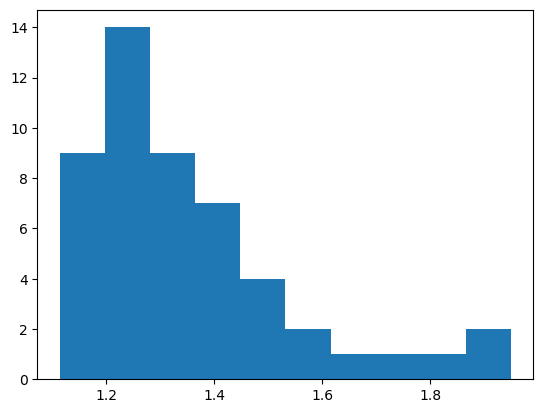

In [5]:
import matplotlib.pyplot as plt
plt.hist(results)

# Gradient-Based Optimization

In [6]:
kernel_config = get_kernel_config(
    dataset,
    graph_kernel_type = 'graph',
    # arguments for marginalized graph kernel
    mgk_hyperparameters_files = ['freesolv/hyperopt/%s/hyperparameters_0.json' % kernel_type],
)
kernel = kernel_config.kernel
alpha = float(open('freesolv/hyperopt/%s/alpha' % kernel_type, 'r').readline())

In [7]:
# optimization
from mgktools.models.regression.GPRgraphdot import GPR
gpr = GPR(kernel=kernel,
          optimizer='L-BFGS-B',
          alpha=alpha,
          normalize_y=True)
gpr.fit(dataset.X, dataset.y, loss='loocv', verbose=True)

|     Sq.Err.|    d(SqErr)|     log|K| |     Cond(K)| t_GPU (s)| t_CPU (s)|
|------------|------------|------------|------------|----------|----------|
|      26.968|      26.968|       -1911|    2.75e+05|        12|        36|
|      34.942|      34.942|     -261.87|  2.1659e+05|        10|        36|
|      29.512|      29.512|     -891.01|  2.8302e+05|        10|        37|
|      27.334|      27.334|     -1455.3|  2.8205e+05|        10|        36|
|      26.806|      26.806|     -1724.4|  2.7766e+05|        10|        38|
|      26.767|      26.767|     -1727.4|  2.7809e+05|        10|        38|
|      26.635|      26.635|     -1739.7|  2.7974e+05|        10|        38|
|       26.45|       26.45|       -1762|  2.8244e+05|        10|        38|
|      25.385|      25.385|     -1723.6|  2.9891e+05|        10|        39|
|      25.156|      25.156|       -1735|  3.0524e+05|        10|        36|
|      24.517|      24.517|     -1604.5|   3.258e+05|        10|        36|
|      24.26

In [8]:
# save optimized hyperparameters
kernel_config.update_from_theta()
kernel_config.save_hyperparameters('freesolv/hyperopt/%s' % kernel_type)